ResNET152 - Trained for ensemble 

    Learning Rate No.of epochs  Accuracy 
     3e-3              3          0.70   ("Error_ResNET152_Training.ipynb")
     2e-4              4          0.75

    However the ResNET152 accuracy was low and couldnt try further for ensemble.

In [ ]:
#importing library 
import numpy as np
import pandas as pd
import time

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cheking the number of cored this system has.
!cat /proc/cpuinfo | grep "cpu cores" | uniq

cpu cores	: 2


In [ ]:
# GPU info
!nvidia-smi

Wed May 12 21:32:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Amount of system RAM available to be used.
from psutil import virtual_memory
ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

Your runtime has 25.5 gigabyte of availabe



In [ ]:
#checking recursive limit 
import sys
print(sys.getrecursionlimit())

1000


In [ ]:
# !pip install git+https://github.com/fastai/fastai.git
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 31.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
#importing fastai library 
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
#Data Download 
path = untar_data(URLs.FOOD)

train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [ ]:
#fixing the seed value 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
def evaluate_performance(y_true, y_predict):
  """
    y_true    : True labels of the Images in test dataset 
    y_predict : Predicted labels of the images in test dataset 

    prints the Confusion Matrix , No.Of Misclassifications, Recall and Food class with maximum and minimum accuracy 

    Used for performance evaluation of any true and predicted labels
  """
  import sklearn.metrics as metrics
  print(f"{metrics.classification_report(y_true.items, y_predict)}\n")

  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  cm1 = confusion_matrix(y_true.items,y_predict)
  print(cm1)

  print("No.of validation set samples predicted correctly ",sum(cm1.diagonal()))
  print("No.of misclassified samples ", len(y_predict)-sum(cm1.diagonal()))

  #Calculating the True Occurences
  true_occ= []
  for i in range(len(cm1)):
    true_occ.append(sum(cm1[:,i]))

  #Calculating the recall for all the categories
  dia = cm1.diagonal()
  prediction_prob=[]
  for i in range(len(cm1)):
    tmp_prob = dia[i]/true_occ[i]
    prediction_prob.append(tmp_prob)

  incorrect_class = prediction_prob.index(min(prediction_prob))
  correct_class = prediction_prob.index(max(prediction_prob))
  print("Food category with more no.of correct predictions ",y_true.classes[correct_class] )
  print("Food category with min no.of correct predictions ",y_true.classes[incorrect_class] )

In [ ]:
#checking if the valid items are the same
def crossverify(data_valid_y):
"""
    data_valid_y : labels of the Validation dataset 
    Returns a Boolean value if the validation dataset has the same labels 

    Expecting the same validation data to perform majority vote ensemble
"""
  oop = pd.DataFrame(data_valid_y.items)
  count_valid = oop.value_counts()
  cat_vd = []
  count_vd=[]
  for i in range(101):
    cat_vd.append(i)
    count_vd.append(count_valid[i])
  dict_shift = dict(zip(cat_vd, count_vd))
  count_id = np.array(count_vd)
  if (count_id[0] == 149 and count_id[1]==138 and count_id[2]==150 and count_id[3]==154):
    return True
  else:
    return False

ResNet152

In [ ]:
bs_res = 16 #batch size
arch = models.resnet152 #importing pretrained ResNET model 
img_size_res = 224 #image size 
    
seed_everything(40)

In [ ]:
#databunch creation 
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=img_size_res)
        .databunch(bs=bs_res)
        .normalize(imagenet_stats))

In [ ]:
if crossverify(data.valid_dl.y):
  top_5 = partial(top_k_accuracy, k=5)
  learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learn.load('/content/drive/MyDrive/food-ResNET101-train-e3') #model trained and saved from the file "Error_ResNET152_Training.ipynb"

  start= time.time()
  Y_valid_predict = []
  for img in data.valid_dl.x:
      tmp_predict = learn.predict(img)
      Y_valid_predict.append(tmp_predict[1])
  end = time.time()
  print({end - start})
else:
  print('Different data')

{629.8130035400391}


In [ ]:
#performance of the resNET model with learning rate 3e-3  
evaluate_performance(data.valid_dl.y,Y_valid_predict)

              precision    recall  f1-score   support

           0       0.58      0.33      0.42       149
           1       0.79      0.65      0.71       138
           2       0.78      0.70      0.74       150
           3       0.70      0.81      0.75       154
           4       0.68      0.69      0.69       141
           5       0.64      0.62      0.63       159
           6       0.80      0.76      0.78       133
           7       0.81      0.88      0.84       136
           8       0.58      0.39      0.47       164
           9       0.61      0.68      0.64       136
          10       0.56      0.59      0.58       143
          11       0.70      0.73      0.71       145
          12       0.75      0.76      0.76       157
          13       0.73      0.72      0.72       148
          14       0.71      0.65      0.68       149
          15       0.51      0.54      0.52       148
          16       0.65      0.78      0.71       167
          17       0.64    

**ResNET-152-Learning Rate**

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-05


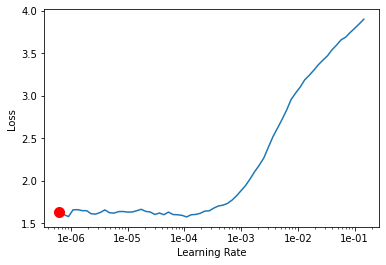

In [ ]:
#changing the learning rate to improve the performance of resNET 
if crossverify(data.valid_dl.y):
    top_5 = partial(top_k_accuracy, k=5)
    learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
    learn.load('/content/drive/MyDrive/food-ResNET101-train-e3')
    learn.unfreeze()
    learn.lr_find()
    learn.recorder.plot(suggestion=True)
else:
  print('Different data')

In [ ]:
# using fastai widget to do data cleaning
from fastai.widgets import *

In [ ]:
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_none()
        .label_from_df(cols=0)
        .transform(ds_tfms, size=224)
        .databunch())

In [ ]:
learn_cln = cnn_learner(data, arch, metrics=[accuracy, top_5])
learn_cln.load('/content/drive/MyDrive/food-ResNET101-train-e3')

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
# manually removing some of the noise in dataset. 
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [ ]:
# !cp /content/models/model.tar.gz /content/drive/'My Drive'/DeepLearning/model.tar.gz
!cp /root/.fastai/data/food-101/cleaned.csv /content/drive/MyDrive/cleaned.csv
#!cp /root/.fastai/data/food-101/cleaned.csv /content/drive/'My Drive'/DeepLearning/finalres152/cleaned.csv

In [ ]:
#creating the databench for the cleaned data  
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='/content/drive/MyDrive/cleaned.csv',
                               ds_tfms=ds_tfms, bs=bs_res, size=img_size_res, num_workers=2).normalize(imagenet_stats)

learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn.load('/content/drive/MyDrive/food-ResNET101-train-e3')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 6.31E-08


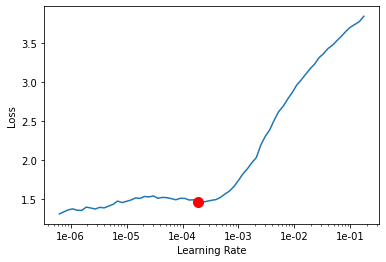

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.784107,1.193214,0.688651,0.894567,32:20
1,1.657583,1.148445,0.705288,0.900442,32:24
2,1.375884,0.914563,0.755793,0.927708,32:22


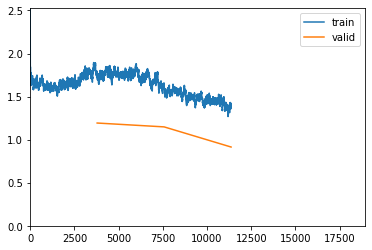

In [ ]:
#Retraining the resNET model with a new learning rate and cleaned dataset 
lr = 2e-4
learn.fit_one_cycle(5, max_lr=slice(2e-5, lr))
learn.save('/content/drive/MyDrive/food-ResNET101-train-e4')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.865458,2.517953,0.401848,0.665743,17:32
1,3.091671,1.969666,0.513003,0.771881,17:36
2,2.781066,1.793346,0.553267,0.802376,17:37


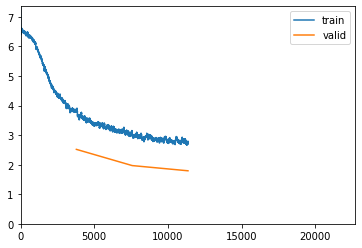

In [ ]:
#Couldnot achieve better accuracy 
# if crossverify(data.valid_dl.y):
#   top_5 = partial(top_k_accuracy, k=5)
#   learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
#   lr = 4e-5
#   learn.fit_one_cycle(6, max_lr=slice(1e-6, lr), pct_start=0.1, final_div=1000, wd=0.1)
#   learn.save('/content/drive/MyDrive/food-ResNET101-train-e6v')
# else:
#   print('Different Data')